In [49]:
import os
import cv2
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# **Vision Transformer**

--------------------------------------------------------------------------------

In [50]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader


# Defining the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the training and testing datasets from Google Drive
train_dataset = datasets.ImageFolder(r"E:\Programming\VS CODE\Python\8th sem\Training", transform=transform)
test_dataset = datasets.ImageFolder(r"E:\Programming\VS CODE\Python\8th sem\NewTest", transform=transform)

# Creating DataLoaders for training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Loading the Vision Transformer model
model = models.vision_transformer.vit_b_16(pretrained=True)

# If a GPU is available, move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Definign the loss function and optimizer
lossfunction = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

c:\Users\Wrishav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Wrishav\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# Training
for epoch in range(10):

    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs) #Output variable will hold the predicted classes
        loss = lossfunction(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        #running_loss += loss.item()
        #if i % 2000 == 1999:    # Printing every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
                  #(epoch + 1, i + 1, running_loss / 2000))
            #running_loss = 0.0
    print(epoch+1)
        

1
2
3
4
5
6
7
8
9
10


In [52]:
print('Finished Training')
# Save the trained model
model_save_path = r"E:\Programming\VS CODE\Python\8th sem\vitModel\ViT_savedModel.pth"
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Finished Training
Model saved to E:\Programming\VS CODE\Python\8th sem\vitModel\ViT_savedModel.pth


In [53]:
predicted_probs = []
true_labels = []

In [54]:
 # Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        softmax = torch.nn.Softmax(dim=1)
        probabilities = softmax(outputs).cpu().numpy()
        predicted_probs.extend(probabilities[:, 1])

print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))

print('Finished Training')


Accuracy of the model on the test images: 62 %
Finished Training


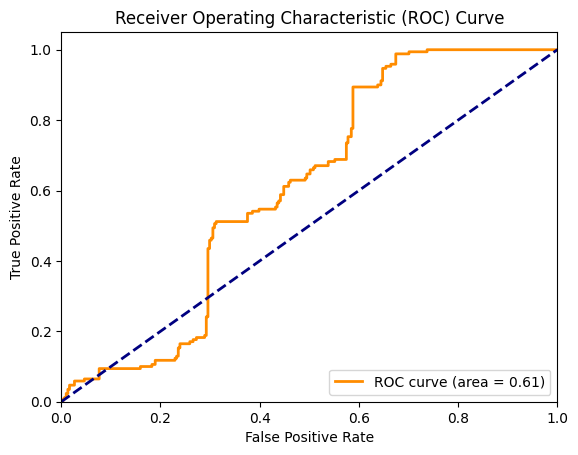

In [55]:
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()